In [1]:
import numpy as np
from brian2 import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
%matplotlib inline

### Pyramidal Cell

In [2]:
constants_PC = {
    'E_na': 55*mV,
    'E_leak': -70*mV,
    'ca_rest': 50*nmole/liter,
    'ca_out': 2*mmole/liter,
    'k_rest': 3.82*mmole/liter,
    'k_out': 3.82*mmole/liter, # remove once bug is fixed
    'k_in': 140*mmole/liter,
    'g_na': 86.0*msiemens/cm**2,  # soma
    'g_nap': 2.2*msiemens/cm**2,  # soma
    'g_hva': 0.34*msiemens/cm**2,  # soma  # 0%DA=0.34, 100%DA=0.272
    'g_dr': 33.8*msiemens/cm**2,  # soma
    'g_ks': 0.14*msiemens/cm**2,  # soma  # 0%DA=0.14, 100%DA=0.07
    'g_c': 2.2*msiemens/cm**2,  # soma
    'g_leak': 1.0/(30*kohm*cm**2),
    'C_m': 1.2*ufarad/cm**2,
    'R_i': 150*ohm*cm,
    'k_nap_alpha_m': 12,  # 0%DA=12, 100%DA=17
    'k_nap_beta_m': 15,  # 0%DA=15, 100%DA=10
    'k_nap_alpha_h': 2.8,  # 0%DA=2.8, 100%DA=2.0
    'k_nap_beta_h': 0.02,  # 0%DA=0.02, 100%DA=0.014286
    'phi_ca': 386*10**(-9),  # soma
    'phi_k': 2.0,
    'F': 96485.33289 * coulomb/mole,  # Faraday's constant
    'tau_ca': 250.0*ms,  # soma
    'tau_k': 7.0*ms,
    'radius_soma': 11.5*um,
    'radius_shell_ca': 0.2*nmeter,
    'radius_shell_k': 70*nmeter,
}

In [10]:
eqns_PC = ''' 

# TOTAL CURRENT
Im = I_leak + I_na + I_dr + I_nap +  I_c + I_ks  + I_hva: amp/meter**2  #


# INJECTED
I : amp (point current)


# LEAK
I_leak = g_leak * (E_leak - v) : amp/meter**2


# SODIUM
I_na = g_na * (E_na - v) * m_na**3 * h_na : amp/meter**2
dm_na/dt = (m_na_inf - m_na) / tau_m_na : 1
m_na_inf = alpha_m_na / (alpha_m_na + beta_m_na) : 1
tau_m_na = 1.0*ms / (alpha_m_na + beta_m_na) : second
alpha_m_na = (-0.2816/mV)*(v + 28*mV) / (-1 + exp(-(v+28*mV)/(9.3*mV))) : 1
beta_m_na = (0.2464/mV)*(v + 1*mV) / (-1 + exp((v+1*mV)/(6*mV))) : 1
dh_na/dt = (h_na_inf - h_na) / tau_h_na : 1
h_na_inf = alpha_h_na / (alpha_h_na + beta_h_na) : 1
tau_h_na = 1.0*ms / (alpha_h_na + beta_h_na) : second
alpha_h_na = 0.098*exp(-(v+43.1*mV)/(20*mV)) : 1
beta_h_na = 1.4 / (1 + exp(-(v+13.1*mV)/(10*mV))) : 1

I_nap = g_nap * (E_na - v) * m_nap : amp/meter**2  #  * h_nap
dm_nap/dt = (m_nap_inf - m_nap) / tau_m_nap : 1
m_nap_inf = alpha_m_nap / (alpha_m_nap + beta_m_nap) : 1
tau_m_nap = 1.0*ms / (alpha_m_nap + beta_m_nap) : second
alpha_m_nap = (-0.2816/mV)*(v+k_nap_alpha_m*mV) / (-1 + exp(-(v+k_nap_alpha_m*mV)/(9.3*mV))) : 1
beta_m_nap = (0.2464/mV)*(v + k_nap_beta_m*mV) / (-1 + exp((v+k_nap_beta_m*mV)/(6*mV))) : 1
dh_nap/dt = (h_nap_inf - h_nap) / tau_h_nap : 1
h_nap_inf = alpha_h_nap / (alpha_h_nap + beta_h_nap) : 1
tau_h_nap = 1.0*ms / (alpha_h_nap + beta_h_nap) : second
alpha_h_nap = k_nap_alpha_h*exp(-(v+42.8477*mV)/(4.0248*mV)) : 1
beta_h_nap = k_nap_beta_h / (1 + exp(-(v-413.9284*mV)/(148.2589*mV))) : 1


# CALCIUM
E_ca = 12.5*mV * log(ca_out / clip(ca_in, 1e-9, 1e10))  : volt  # note: clip
surf_area = 4*pi*radius_soma**2 : meter**2
vol_shell_ca = 4*pi/3*((radius_soma + radius_shell_ca)**3 - radius_soma**3) : meter**3
dca_in/dt = -phi_ca * (I_hva * surf_area / (F*vol_shell_ca)) + (ca_rest - ca_in)/tau_ca : mole/meter**3

I_hva = g_hva * (E_ca - v) * u_hva**2 * v_hva  : amp/meter**2
du_hva/dt = (u_hva_inf - u_hva) / tau_u_hva : 1
u_hva_inf = 1.0 / (1 + exp(-(v + 24.6*mV)/(11.3*mV))) : 1
#tau_u_hva = clip(ms * 1.25 / cosh(-(0.031/mV)*((v+37.1*mV))), 0.3*ms, 10**(10)*ms) : second  # sech = 1/cosh  # note:clip, mV
tau_u_hva = 1.25*ms / cosh(-(0.031/mV)*((v+37.1*mV))) : second  # sech = 1/cosh
dv_hva/dt = (v_hva_inf - v_hva) / tau_v_hva : 1
v_hva_inf = 1.0 / (1 + exp((v + 12.6*mV)/(18.9*mV))) : 1
tau_v_hva = 420.0*ms : second # blazeit


# POTASSIUM
E_k = 25.0*mV * log(k_out / k_in) : volt
vol_shell_k = 4*pi/3*((radius_soma + radius_shell_k)**3 - radius_soma**3) : meter**3
# dk_out/dt = -phi_k * ((I_dr + I_ks + I_c)*surf_area / (F*vol_shell_k)) + (k_rest - k_in)/tau_k : mole/meter**3

I_dr = g_dr * (E_k - v) * n_dr**4 : amp/meter**2
dn_dr/dt = (n_dr_inf - n_dr) / tau_n_dr : 1
n_dr_inf = alpha_n_dr / (alpha_n_dr + beta_n_dr) : 1
tau_n_dr = 1.0*ms / (alpha_n_dr + beta_n_dr) : second
alpha_n_dr = (-0.018/mV)*(v - 13*mV) / (-1 + exp(-(v - 13*mV)/(25*mV))) : 1
beta_n_dr = (0.0054/mV)*(v - 23*mV) / (-1 + exp((v - 23*mV)/(12*mV))) : 1

I_ks =  g_ks * (E_k - v) * a_ks * b_ks : amp/meter**2
da_ks/dt = (a_ks_inf - a_ks) / tau_a_ks : 1
a_ks_inf = 1.0 / (1 + exp(-(v + 34*mV)/(6.5*mV))) : 1
tau_a_ks = 6.0*ms : second
db_ks/dt = (b_ks_inf - b_ks) / tau_b_ks : 1
b_ks_inf = 1.0 / (1 + exp((v + 65*mV)/(6.6*mV))) : 1
tau_b_ks = ms*(200 + 3200 / (1 + exp(-(v + 63.6*mV)/(4*mV)))) : second

I_c = g_c * (E_k - v) * c_c**2 : amp/meter**2
dc_c/dt = (c_c_inf - c_c) / tau_c_c : 1
c_c_inf = alpha_c_c / (alpha_c_c + beta_c_c) : 1
tau_c_c = ms*clip(1.0 / (alpha_c_c + beta_c_c), 1.1, 1e10) : second
alpha_c_c = (-0.00642*(v_s/mV) - 0.1152) / (-1 + exp(-(v_s + 18*mV)/(12*mV))) : 1
beta_c_c = 1.7 * exp(-(v_s + 152*mV)/(30*mV)) : 1
v_s = v + 40*mV*log10(clip(ca_in, 1e-9, 1e10)/(umole/liter)) : volt  # note: clip

'''

Starting simulation at t=0. s for a duration of 10. ms
0.01 (100%) simulated in < 1s
Starting simulation at t=10. ms for a duration of 100. ms
0.1 (100%) simulated in 5s


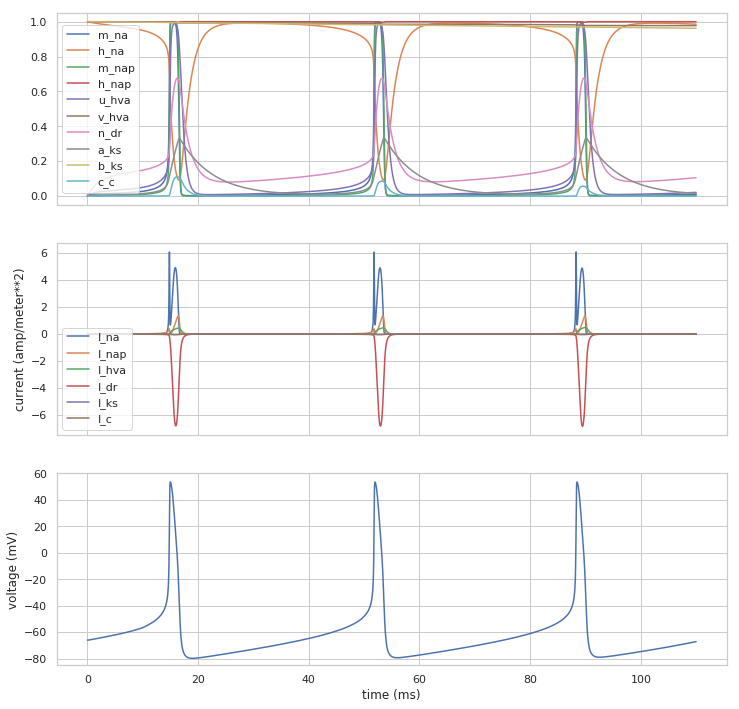

In [18]:
cell_PC = Soma(diameter=23.0*um)
cell_PC.basal_PC = Cylinder(length=150*um, diameter=16.0*um, n=10)
cell_PC.proximal_PC = Cylinder(length=400*um, diameter=2.6*um, n=10)
cell_PC.proximal_PC.distal_PC = Cylinder(length=400*um, diameter=2.6*um, n=10)

PC = SpatialNeuron(morphology=cell_PC, model=eqns_PC, method='exponential_euler',
    refractory="m_na > 0.4", threshold="m_na > 0.5",  # todo
    namespace=constants_PC, Cm=constants_PC['C_m'], Ri=constants_PC['R_i'])

v_mon = StateMonitor(PC, 'v', record=True)
spike_mon = SpikeMonitor(PC)

I_na_mon = StateMonitor(PC, 'I_na', record=True)
I_nap_mon = StateMonitor(PC, 'I_nap', record=True)
I_hva_mon = StateMonitor(PC, 'I_hva', record=True)
I_dr_mon = StateMonitor(PC, 'I_dr', record=True)
I_ks_mon = StateMonitor(PC, 'I_ks', record=True)
I_c_mon = StateMonitor(PC, 'I_c', record=True)
m_na_mon = StateMonitor(PC, 'm_na', record=True)
h_na_mon = StateMonitor(PC, 'h_na', record=True)
m_nap_mon = StateMonitor(PC, 'm_nap', record=True)
h_nap_mon = StateMonitor(PC, 'h_nap', record=True)
u_hva_mon = StateMonitor(PC, 'u_hva', record=True)
v_hva_mon = StateMonitor(PC, 'v_hva', record=True)
n_dr_mon = StateMonitor(PC, 'n_dr', record=True)
a_ks_mon = StateMonitor(PC, 'a_ks', record=True)
b_ks_mon = StateMonitor(PC, 'b_ks', record=True)
c_c_mon = StateMonitor(PC, 'c_c', record=True)
ca_mon = StateMonitor(PC, 'ca_in', record=True)

defaultclock.dt = 0.01*ms

PC.v = -66.0*mV
PC.I = 0*uA
PC.m_na = 0
PC.h_na = 1
PC.m_nap = 0
PC.h_nap = 1
PC.u_hva = 0
PC.v_hva = 1
PC.n_dr = 0
PC.a_ks = 0
PC.b_ks = 1
PC.c_c = 0
PC.ca_in = 50*nmole/liter
# PC.k_out = 3.82*nmole/liter

cell_PC.basal_PC.Cm = 1.92 * constants_PC['C_m']  # todo: also R_m of dendrites?
cell_PC.basal_PC.g_na = 28.0 * msiemens/cm**2
cell_PC.basal_PC.g_nap = 1.0 * msiemens/cm**2
cell_PC.basal_PC.g_hva = 0.7 * msiemens/cm**2
cell_PC.basal_PC.g_dr = 9.2 * msiemens/cm**2
cell_PC.basal_PC.g_ks = 0.24 * msiemens/cm**2
cell_PC.basal_PC.g_c = 3.8 * msiemens/cm**2
cell_PC.basal_PC.tau_ca = 120*ms
cell_PC.basal_PC.phi_ca = 965e-9

cell_PC.proximal_PC.Cm = 1.92 * constants_PC['C_m']
cell_PC.proximal_PC.g_na = 28.0 * msiemens/cm**2
cell_PC.proximal_PC.g_nap = 1.0 * msiemens/cm**2
cell_PC.proximal_PC.g_hva = 0.7 * msiemens/cm**2
cell_PC.proximal_PC.g_dr = 9.2 * msiemens/cm**2
cell_PC.proximal_PC.g_ks = 0.24 * msiemens/cm**2
cell_PC.proximal_PC.g_c = 3.8 * msiemens/cm**2
cell_PC.proximal_PC.tau_ca = 120*ms
cell_PC.proximal_PC.phi_ca = 965e-9

cell_PC.proximal_PC.distal_PC.Cm = 1.92 * constants_PC['C_m']
cell_PC.proximal_PC.distal_PC.g_na = 28.0 * msiemens/cm**2
cell_PC.proximal_PC.distal_PC.g_nap = 0.0 * msiemens/cm**2
cell_PC.proximal_PC.distal_PC.g_hva = 0.34 * msiemens/cm**2
cell_PC.proximal_PC.distal_PC.g_dr = 9.2 * msiemens/cm**2
cell_PC.proximal_PC.distal_PC.g_ks = 0.24 * msiemens/cm**2
cell_PC.proximal_PC.distal_PC.g_c = 2.2 * msiemens/cm**2
cell_PC.proximal_PC.distal_PC.tau_ca = 80*ms
cell_PC.proximal_PC.distal_PC.phi_ca = 965e-9


briannet_PC = Network(PC, v_mon, spike_mon, I_na_mon, I_nap_mon, I_hva_mon, I_dr_mon, I_ks_mon, I_c_mon,
    m_na_mon, h_na_mon, m_nap_mon, h_nap_mon, u_hva_mon, v_hva_mon, n_dr_mon, a_ks_mon, b_ks_mon, c_c_mon, ca_mon)

briannet_PC.run(10*ms, report='text')
PC.main.I = 60*pamp  # somatic current injection
briannet_PC.run(100*ms, report='text')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
ax1.plot(v_mon.t/ms, m_na_mon.m_na[0,:], label='m_na')
ax1.plot(v_mon.t/ms, h_na_mon.h_na[0,:], label='h_na')
ax1.plot(v_mon.t/ms, m_nap_mon.m_nap[0,:], label='m_nap')
ax1.plot(v_mon.t/ms, h_nap_mon.h_nap[0,:], label='h_nap')
ax1.plot(v_mon.t/ms, u_hva_mon.u_hva[0,:], label='u_hva')
ax1.plot(v_mon.t/ms, v_hva_mon.v_hva[0,:], label='v_hva')
ax1.plot(v_mon.t/ms, n_dr_mon.n_dr[0,:], label='n_dr')
ax1.plot(v_mon.t/ms, a_ks_mon.a_ks[0,:], label='a_ks')
ax1.plot(v_mon.t/ms, b_ks_mon.b_ks[0,:], label='b_ks')
ax1.plot(v_mon.t/ms, c_c_mon.c_c[0,:], label='c_c')
ax1.legend()
ax2.plot(v_mon.t/ms, I_na_mon.I_na[0,:]/(amp/meter**2), label='I_na')
ax2.plot(v_mon.t/ms, I_nap_mon.I_nap[0,:]/(amp/meter**2), label='I_nap')
ax2.plot(v_mon.t/ms, I_hva_mon.I_hva[0,:]/(amp/meter**2), label='I_hva')
ax2.plot(v_mon.t/ms, I_dr_mon.I_dr[0,:]/(amp/meter**2), label='I_dr')
ax2.plot(v_mon.t/ms, I_ks_mon.I_ks[0,:]/(amp/meter**2), label='I_ks')
ax2.plot(v_mon.t/ms, I_c_mon.I_c[0,:]/(amp/meter**2), label='I_c')
ax2.set(ylabel='current (amp/meter**2)')
ax2.legend(loc='lower left')
ax3.plot(v_mon.t/ms, v_mon.v[0,:]/mV)
ax3.set(xlabel='time (ms)', ylabel='voltage (mV)', ylim=((-85, 60)))
plt.show()

### GABA Interneuron Model

In [ ]:
constants_IN = {
    'E_na': 55*mV,
    'E_leak': -68*mV,
    'k_rest': 3.82*mmole/liter,
    'k_out': 3.82*mmole/liter, #remove
    'k_in': 140*mmole/liter,
    'g_na': 100.0*msiemens/cm**2,  # soma
    'g_dr': 40.0*msiemens/cm**2,  # soma
#     'g_leak': 0.3*msiemens/cm**2,  # todo
    'g_leak': 1.0/(100*kohm*cm**2),  # todo
    'C_m': 1.0*ufarad/cm**2,
    'R_i': 150*ohm*cm,
    'phi_k': 386*10**(-9),  # soma
    'F': 96485.33289 * coulomb/mole,  # Faraday's constant
    'V_shell_k': 4*np.pi/3 * ((7.5*um+70*nmeter)**3 - (7.5*um)**3),  # soma  # shell of thickness 70 nm
    'tau_k': 7.0*ms,
}

In [ ]:
eqns_IN = ''' 

# TOTAL CURRENT
Im = I_leak + I_na + I_dr: amp/meter**2 


# INJECTED
I : amp (point current)


# LEAK
I_leak = g_leak * (E_leak - v) : amp/meter**2


# SODIUM
I_na = g_na * (E_na - v) * m_na**3 * h_na : amp/meter**2
dm_na/dt = (m_na_inf - m_na) / tau_m_na : 1
m_na_inf = alpha_m_na / (alpha_m_na + beta_m_na) : 1
tau_m_na = 1.0*ms / (alpha_m_na + beta_m_na) : second
alpha_m_na = 4.2*exp((v + 34.5*mV)/(11.57*mV)) : 1
beta_m_na = 4.2*exp(-(v + 34.5*mV)/(27*mV)) : 1
dh_na/dt = (h_na_inf - h_na) / tau_h_na : 1
h_na_inf = alpha_h_na / (alpha_h_na + beta_h_na) : 1
tau_h_na = 1.0*ms / (alpha_h_na + beta_h_na) : second
alpha_h_na = 0.09*exp(-(v + 45*mV)/(33*mV)) : 1
beta_h_na = 0.09*exp((v + 45*mV)/(12.2*mV)) : 1


# POTASSIUM
E_k = 25.0*mV * log(k_out / k_in) : volt
# dk_out/dt = -phi_k * (I_dr*(meter**2) / (F*V_shell_k)) + (k_rest - k_in)/tau_k : mole/meter**3

I_dr = g_dr * (E_k - v) * n_dr**4 : amp/meter**2
dn_dr/dt = (n_dr_inf - n_dr) / tau_n_dr : 1
n_dr_inf = alpha_n_dr / (alpha_n_dr + beta_n_dr) : 1
tau_n_dr = 1.0*ms / (alpha_n_dr + beta_n_dr) : second
alpha_n_dr = 0.3*(exp((v + 35*mV)/(10.67*mV))) : 1
beta_n_dr = 0.3*(exp(-(v + 35*mV)/(42.68*mV))) : 1

'''

In [ ]:
soma_IN = Soma(diameter=15.0*um)
# soma_IN = Cylinder(length=10*cm, diameter=2*238*um, n=1000, type='axon')

IN = SpatialNeuron(morphology=soma_IN, model=eqns_IN, method='exponential_euler',
    refractory="m_na > 0.4", threshold="m_na > 0.5",  # todo
    namespace=constants_IN, Cm=constants_IN['C_m'], Ri=constants_IN['R_i'])

v_mon = StateMonitor(IN, 'v', record=True)
m_na_mon = StateMonitor(IN, 'm_na', record=True)
h_na_mon = StateMonitor(IN, 'h_na', record=True)
n_dr_mon = StateMonitor(IN, 'n_dr', record=True)
s_mon = SpikeMonitor(IN)

defaultclock.dt = 0.01*ms
IN.v = -66.0*mV
IN.m_na = 0
IN.h_na = 1
IN.n_dr = 0.5
# IN.k_out = 3.82*nmole/liter

briannet_IN = Network(IN, v_mon, m_na_mon, h_na_mon, n_dr_mon)

IN.I = 0*uamp  # current injection
briannet_IN.run(10*ms, report='text')
IN.I = 1*namp  # current injection
briannet_IN.run(3*ms, report='text')
IN.I = 0*uamp  # current injection
briannet_IN.run(10*ms, report='text')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(m_na_mon.m_na[0,:], label='m')
ax1.plot(h_na_mon.h_na[0,:], label='h')
ax1.plot(n_dr_mon.n_dr[0,:], label='n')
ax1.legend()
ax2.plot(v_mon.t/ms, v_mon.v[0,:]/mV)
ax2.set(xlabel='time (ms)', ylabel='voltage (mV)', ylim=((-85, 20)))
plt.show()